# Document AI | Inference at line level with a Document Understanding model (LiLT fine-tuned on DocLayNet dataset)

- Credit: 
  - notebook created from the notebook [Fine_tune_LiLT_on_a_custom_dataset_in_any_language.ipynb](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LiLT/Fine_tune_LiLT_on_a_custom_dataset%2C_in_any_language.ipynb) of [Niels ROGGE](https://github.com/NielsRogge)
  -  dataset from IBM Research ([DocLayNet](https://github.com/DS4SD/DocLayNet))
- Author of this notebook: [Pierre GUILLOU](https://www.linkedin.com/in/pierreguillou/)
- Blog post: [Document AI | Document Understanding model at line level with LiLT and DocLayNet dataset](https://medium.com/@pierre_guillou/document-ai-document-understanding-model-at-line-level-with-lilt-tesseract-and-doclaynet-dataset-347107a643b8)
- Other Notebook: [Document AI | Fine-tune LiLT on DocLayNet base in any language at line level (chunk of 384 tokens with overlap)](https://github.com/piegu/language-models/blob/master/Fine_tune_LiLT_on_DocLayNet_base_in_any_language_at_linelevel_ml_384.ipynb)
- Date: 02/10/2023

## Inference at line level

LiLT (Language-Independent Layout Transformer) is a Document Understanding model that uses both layout and text in order to detect labels of bounding boxes.

It relies on an external OCR engine to get words and bboxes from the document image. Thus, let's run an OCR engine ourselves ([PyTesseract](https://github.com/madmaze/pytesseract#python-tesseract)) as we'll need to do it in real life.

Within this notebook, run our own OCR on any PDF document to get the bounding boxes, then run LiLT (already fine-tuned on the DocLayNet dataset at line level: [pierreguillou/lilt-xlm-roberta-base-finetuned-with-DocLayNet-base-at-linelevel-ml384](https://huggingface.co/pierreguillou/lilt-xlm-roberta-base-finetuned-with-DocLayNet-base-at-linelevel-ml384)) on the individual tokens and visualize the result at lines level!

Sources:

- [Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLM/Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb)
- https://www.kaggle.com/jpmiller/layoutlm-starter
- https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0 

## Install PDF2image & PyTesseract OCR 

PDF2image

In [1]:
%%capture
!apt-get install poppler-utils
!pip install pdf2image

PyTesseract OCR

In [2]:
%%capture
# !sudo apt install tesseract-ocr # english
!sudo apt-get install tesseract-ocr-por # portuguese
!pip install pytesseract

## Kill runtime

In Colab, it is needed in order to update libraries with their new installed version.

In [ ]:
import os
os.kill(os.getpid(), 9)

## Set-up environment

### Libraries

In [1]:
!pip install -q transformers datasets

In [42]:
from operator import itemgetter
import collections
import pdf2image
from pdf2image import convert_from_path
import pytesseract
import pandas as pd
import numpy as np
import pickle
import random
from google.colab import files
import tempfile
from matplotlib import font_manager
from PIL import Image, ImageDraw, ImageFont
import cv2
# In Colab, use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow
from IPython.display import display

### Key parameters

In [3]:
# categories colors
label2color = {
    'Caption': 'brown',
    'Footnote': 'orange',
    'Formula': 'gray',
    'List-item': 'yellow',
    'Page-footer': 'red',
    'Page-header': 'red',
    'Picture': 'violet',
    'Section-header': 'orange',
    'Table': 'green',
    'Text': 'blue',
    'Title': 'pink'
    }

# domains = ["Financial Reports", "Manuals", "Scientific Articles", "Laws & Regulations", "Patents", "Government Tenders"]
# domain_names = [domain_name.lower().replace(" ", "_").replace("&", "and") for domain_name in domains]

# bounding boxes start and end of a sequence
cls_box = [0, 0, 0, 0]
sep_box = cls_box

# DocLayNet dataset
dataset_name = "pierreguillou/DocLayNet-small"
dataset_name_suffix = dataset_name.replace("pierreguillou/DocLayNet-", "")

# model_id = "pierreguillou/lilt-xlm-roberta-base-finetuned-funsd-iob-original"
model_id = "pierreguillou/lilt-xlm-roberta-base-finetuned-with-DocLayNet-base-at-linelevel-ml384"

# parameters for tokenization and overlap
# The maximum length of a feature (sequence)
if str(384) in model_id:
  max_length = 384 
elif str(512) in model_id:
  max_length = 512 
else:
  print("Error with max_length of chunks!")
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

### Functions

#### General

In [4]:
# get text and bounding boxes from an image
# https://stackoverflow.com/questions/61347755/how-can-i-get-line-coordinates-that-readed-by-tesseract
# https://medium.com/geekculture/tesseract-ocr-understanding-the-contents-of-documents-beyond-their-text-a98704b7c655
def get_data(results, factor, conf_min=0):

  data = {}
  for i in range(len(results['line_num'])):
    level = results['level'][i]
    block_num = results['block_num'][i]
    par_num = results['par_num'][i]
    line_num = results['line_num'][i]
    top, left = results['top'][i], results['left'][i]
    width, height = results['width'][i], results['height'][i]
    conf = results['conf'][i]
    text = results['text'][i]
    if not (text == '' or text.isspace()):
      if conf >= conf_min:
        tup = (text, left, top, width, height)
        if block_num in list(data.keys()):
          if par_num in list(data[block_num].keys()):
            if line_num in list(data[block_num][par_num].keys()):
              data[block_num][par_num][line_num].append(tup)
            else:
              data[block_num][par_num][line_num] = [tup]
          else:
            data[block_num][par_num] = {}
            data[block_num][par_num][line_num] = [tup]
        else:
            data[block_num] = {}
            data[block_num][par_num] = {}
            data[block_num][par_num][line_num] = [tup]

  # get paragraphs dicionnary with list of lines
  par_data = {}
  par_idx = 1
  for _, b  in data.items():
    for _, p in b.items():
      line_data = {}
      line_idx = 1
      for _, l in p.items():
        line_data[line_idx] = l
        line_idx += 1
      par_data[par_idx] = line_data 
      par_idx += 1

  # get lines of texts, grouped by paragraph
  lines = list()
  row_indexes = list()
  row_index = 0
  for _,par in par_data.items():
    count_lines = 0
    for _,line in par.items():
      if count_lines == 0: row_indexes.append(row_index)
      line_text = ' '.join([item[0] for item in line])
      lines.append(line_text)
      count_lines += 1
      row_index += 1
    # lines.append("\n")
    row_index += 1
  # lines = lines[:-1]
  
  # get paragraphes boxes (par_boxes)
  # get lines boxes (line_boxes)
  par_boxes = list()
  par_idx = 1
  line_boxes = list()
  line_idx = 1
  for _, par in par_data.items():
    xmins, ymins, xmaxs, ymaxs = list(), list(), list(), list()
    for _, line in par.items():
      xmin, ymin = line[0][1], line[0][2]
      xmax, ymax = (line[-1][1] + line[-1][3]), (line[-1][2] + line[-1][4])
      line_boxes.append([int(xmin/factor), int(ymin/factor), int(xmax/factor), int(ymax/factor)])
      xmins.append(xmin)
      ymins.append(ymin)
      xmaxs.append(xmax)
      ymaxs.append(ymax)
      line_idx += 1
    xmin, ymin, xmax, ymax = min(xmins), min(ymins), max(xmaxs), max(ymaxs)
    par_boxes.append([int(xmin/factor), int(ymin/factor), int(xmax/factor), int(ymax/factor)])
    par_idx += 1

  return lines, row_indexes, par_boxes, line_boxes #data, par_data #

# rescale image to get 300dpi
def set_image_dpi_resize(image):
    """
    Rescaling image to 300dpi while resizing
    :param image: An image
    :return: A rescaled image
    """
    length_x, width_y = image.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    image_resize = image.resize(size, Image.Resampling.LANCZOS)
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='1.png')
    temp_filename = temp_file.name
    image_resize.save(temp_filename, dpi=(300, 300))
    return factor, temp_filename

In [5]:
# it is important that each bounding box should be in (upper left, lower right) format.
# source: https://github.com/NielsRogge/Transformers-Tutorials/issues/129
def upperleft_to_lowerright(bbox):
  x0, y0, x1, y1 = tuple(bbox)
  if bbox[2] < bbox[0]:
    x0 = bbox[2]
    x1 = bbox[0] 
  if bbox[3] < bbox[1]:
    y0 = bbox[3]
    y1 = bbox[1] 
  return [x0, y0, x1, y1]

# convert boundings boxes (left, top, width, height) format to (left, top, left+widght, top+height) format. 
def convert_box(bbox):
    x, y, w, h = tuple(bbox) # the row comes in (left, top, width, height) format
    return [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 

# LiLT model gets 1000x10000 pixels images
def normalize_box(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

# LiLT model gets 1000x10000 pixels images
def denormalize_box(bbox, width, height):
    return [
        int(width * (bbox[0] / 1000)),
        int(height * (bbox[1] / 1000)),
        int(width* (bbox[2] / 1000)),
        int(height * (bbox[3] / 1000)),
    ]

# get back original size
def original_box(box, original_width, original_height, coco_width, coco_height):
    return [
        int(original_width * (box[0] / coco_width)),
        int(original_height * (box[1] / coco_height)),
        int(original_width * (box[2] / coco_width)),
        int(original_height* (box[3] / coco_height)),
    ]

def get_blocks(bboxes_block, categories, texts):

 # get list of unique block boxes
    bbox_block_dict, bboxes_block_list, bbox_block_prec = dict(), list(), list()
    for count_block, bbox_block in enumerate(bboxes_block):
      if bbox_block != bbox_block_prec:
        bbox_block_indexes = [i for i, bbox in enumerate(bboxes_block) if bbox == bbox_block]
        bbox_block_dict[count_block] = bbox_block_indexes
        bboxes_block_list.append(bbox_block)
      bbox_block_prec = bbox_block

    # get list of categories and texts by unique block boxes
    category_block_list, text_block_list = list(), list()
    for bbox_block in bboxes_block_list:
      count_block = bboxes_block.index(bbox_block)
      bbox_block_indexes = bbox_block_dict[count_block]
      category_block = np.array(categories, dtype=object)[bbox_block_indexes].tolist()[0]
      category_block_list.append(category_block)
      text_block = np.array(texts, dtype=object)[bbox_block_indexes].tolist()
      text_block = [text.replace("\n","").strip() for text in text_block]
      if id2label[category_block] == "Text" or id2label[category_block] == "Caption" or id2label[category_block] == "Footnote":
        text_block = ' '.join(text_block)
      else:
        text_block = '\n'.join(text_block)
      text_block_list.append(text_block)

    return bboxes_block_list, category_block_list, text_block_list

# function to sort bounding boxes
def get_sorted_boxes(bboxes):

  # sort by y from page top to bottom 
  sorted_bboxes = sorted(bboxes, key=itemgetter(1), reverse=False)
  y_list = [bbox[1] for bbox in sorted_bboxes]

  # sort by x from page left to right when boxes with same y
  if len(list(set(y_list))) != len(y_list):
    y_list_duplicates_indexes = dict()
    y_list_duplicates = [item for item, count in collections.Counter(y_list).items() if count > 1]
    for item in y_list_duplicates:
      y_list_duplicates_indexes[item] = [i for i, e in enumerate(y_list) if e == item]
      bbox_list_y_duplicates = sorted(np.array(sorted_bboxes, dtype=object)[y_list_duplicates_indexes[item]].tolist(), key=itemgetter(0), reverse=False)
      np_array_bboxes = np.array(sorted_bboxes)
      np_array_bboxes[y_list_duplicates_indexes[item]] = np.array(bbox_list_y_duplicates)
      sorted_bboxes = np_array_bboxes.tolist()

  return sorted_bboxes

# sort data from y = 0 to end of page (and after, x=0 to end of page when necessary)
def sort_data(bboxes, categories, texts):

    sorted_bboxes = get_sorted_boxes(bboxes)
    sorted_bboxes_indexes = [bboxes.index(bbox) for bbox in sorted_bboxes]
    sorted_categories = np.array(categories, dtype=object)[sorted_bboxes_indexes].tolist()
    sorted_texts = np.array(texts, dtype=object)[sorted_bboxes_indexes].tolist()

    return sorted_bboxes, sorted_categories, sorted_texts

# sort data from y = 0 to end of page (and after, x=0 to end of page when necessary)
def sort_data_wo_labels(bboxes, texts):

    sorted_bboxes = get_sorted_boxes(bboxes)
    sorted_bboxes_indexes = [bboxes.index(bbox) for bbox in sorted_bboxes]
    sorted_texts = np.array(texts, dtype=object)[sorted_bboxes_indexes].tolist()

    return sorted_bboxes, sorted_texts

#### PDF processing

In [6]:
# get filaneme and images of PDF pages
def pdf_to_images(uploaded_pdf):

    # file name of the uploaded PDF
    filename = next(iter(uploaded_pdf))

    try:
      images = convert_from_path(str(filename))
      num_imgs = len(images)
      print(f'The PDF "{filename}"" was converted to {num_imgs} images.')
      print("Now, you can extract data from theses images (text, bounding boxes...).")
    except:
      print(f"Error with the PDF {filename}:it was not converted to images.")
      print()
    else:
      # display images
      if num_imgs > 0:

        import matplotlib.pyplot as plt
        %matplotlib inline

        plt.figure(figsize=(20,10))
        columns = 5
        for i, image in enumerate(images):
            plt.subplot(num_imgs / columns + 1, columns, i + 1)
            plt.xticks(color="white")
            plt.yticks(color="white")
            plt.tick_params(bottom = False)
            plt.tick_params(left = False)
            plt.imshow(image)

        return filename, images

In [7]:
# Extraction of image data (text and bounding boxes)
def extraction_data_from_image(images):

    num_imgs = len(images)
    if num_imgs > 0:

        # https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/
        custom_config = r'--oem 3 --psm 3' # default config PyTesseract: --oem 3 --psm 3
        results, lines, row_indexes, par_boxes, line_boxes = dict(), dict(), dict(), dict(), dict()
        images_ids_list, lines_list, par_boxes_list, line_boxes_list, images_list, page_no_list, num_pages_list = list(), list(), list(), list(), list(), list(), list()
        
        
        try: 
            for i,image in enumerate(images):
                # image preprocessing
                # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
                img = image.copy()
                factor, path_to_img = set_image_dpi_resize(img) # Rescaling to 300dpi
                img = Image.open(path_to_img)
                img = np.array(img, dtype='uint8') # convert PIL to cv2
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # gray scale image
                ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
                    
                # OCR PyTesseract
                results[i] = pytesseract.image_to_data(img, lang='por', config=custom_config, output_type=pytesseract.Output.DICT)

                lines[i], row_indexes[i], par_boxes[i], line_boxes[i] = get_data(results[i], factor, conf_min=0)
                lines_list.append(lines[i])
                par_boxes_list.append(par_boxes[i])
                line_boxes_list.append(line_boxes[i])
                images_ids_list.append(i)
                images_list.append(images[i])
                page_no_list.append(i)
                num_pages_list.append(num_imgs)

        except:
            print(f"There was an error within the extraction of text of page {i} by the OCR!")
        else: 
            from datasets import Dataset
            dataset = Dataset.from_dict({"images_ids": images_ids_list, "images": images_list, "page_no": page_no_list, "num_pages": num_pages_list, "texts": lines_list, "bboxes_line": line_boxes_list})
                    
            print(f"The text data was successfully extracted by the OCR!")

            return dataset, lines, row_indexes, par_boxes, line_boxes

#### Inference

In [8]:
def prepare_inference_features(example, cls_box = cls_box, sep_box = sep_box):

  images_ids_list, chunks_ids_list, input_ids_list, attention_mask_list, bb_list = list(), list(), list(), list(), list()

  # get batch
  # batch_page_hash = example["page_hash"] 
  batch_images_ids = example["images_ids"]
  batch_images = example["images"]
  batch_bboxes_line = example["bboxes_line"]
  # batch_categories = example["categories"]
  batch_texts = example["texts"] 
  # batch_original_width, batch_original_height = example["original_width"] , example["original_height"] 
  batch_images_size = [image.size for image in batch_images]

  batch_width, batch_height = [image_size[0] for image_size in batch_images_size], [image_size[1] for image_size in batch_images_size]

  # add a dimension if not a batch but only one image
  if not isinstance(batch_images_ids, list): 
    batch_images_ids = [batch_images_ids]
    batch_images = [batch_images]
    batch_bboxes_line = [batch_bboxes_line]
    # batch_categories = [batch_categories]
    batch_texts = [batch_texts]
    # batch_original_width, batch_original_height = [batch_original_width], [batch_original_height] 
    batch_width, batch_height = [batch_width], [batch_height] 

        
  # process all images of the batch
  for num_batch, (image_id, boxes, texts, width, height) in enumerate(zip(batch_images_ids, batch_bboxes_line, batch_texts, batch_width, batch_height)):
    tokens_list = []
    bboxes_list = []

    # add a dimension if only on image
    if not isinstance(texts, list):
      texts, boxes = [texts], [boxes]

    # convert boxes to original
    normalize_bboxes_line = [normalize_box(upperleft_to_lowerright(box), width, height) for box in boxes]

    # sort boxes with texts
    # we want sorted lists from top to bottom of the image
    boxes, texts = sort_data_wo_labels(normalize_bboxes_line, texts)

    count = 0
    for box, text in zip(boxes, texts):
      tokens = tokenizer.tokenize(text)
      num_tokens = len(tokens) # get number of tokens
      tokens_list.extend(tokens)

      bboxes_list.extend([box] * num_tokens) # number of boxes must be the same as the number of tokens

    # use of return_overflowing_tokens=True / stride=doc_stride
    # to get parts of image with overlap
    # source: https://huggingface.co/course/chapter6/3b?fw=tf#handling-long-contexts
    encodings = tokenizer(" ".join(texts), 
                          truncation=True,
                          padding="max_length", 
                          max_length=max_length, 
                          stride=doc_stride, 
                          return_overflowing_tokens=True, 
                          return_offsets_mapping=True
                          )

    otsm = encodings.pop("overflow_to_sample_mapping")
    offset_mapping = encodings.pop("offset_mapping")

    # Let's label those examples and get their boxes   
    sequence_length_prev = 0   
    for i, offsets in enumerate(offset_mapping):
      # truncate tokens, boxes and labels based on length of chunk - 2 (special tokens <s> and </s>)
      sequence_length = len(encodings.input_ids[i]) - 2
      if i == 0: start = 0
      else: start += sequence_length_prev - doc_stride
      end = start + sequence_length
      sequence_length_prev = sequence_length

      # get tokens, boxes and labels of this image chunk
      bb = [cls_box] + bboxes_list[start:end] + [sep_box]

      # as the last chunk can have a length < max_length
      # we must to add [tokenizer.pad_token] (tokens), [sep_box] (boxes) and [-100] (labels)
      if len(bb) < max_length:
        bb = bb + [sep_box] * (max_length - len(bb))

      # append results
      input_ids_list.append(encodings["input_ids"][i])
      attention_mask_list.append(encodings["attention_mask"][i])
      bb_list.append(bb)
      images_ids_list.append(image_id)
      chunks_ids_list.append(i)
        
  return {
      "images_ids": images_ids_list,
      "chunk_ids": chunks_ids_list,
      "input_ids": input_ids_list,
      "attention_mask": attention_mask_list,
      "normalized_bboxes": bb_list,
  }

In [9]:
import torch.nn.functional as F

# get predictions at token level
def predictions_token_level(images, custom_encoded_dataset):

    num_imgs = len(images)
    if num_imgs > 0:

        chunk_ids, input_ids, bboxes, outputs, token_predictions  = dict(), dict(), dict(), dict(), dict()
        images_ids_list = list()

        for i,encoding in enumerate(custom_encoded_dataset):

            # get custom encoded data
            image_id = encoding['images_ids']
            chunk_id = encoding['chunk_ids']
            input_id = torch.tensor(encoding['input_ids'])[None]
            attention_mask = torch.tensor(encoding['attention_mask'])[None]
            bbox = torch.tensor(encoding['bbox'])[None]

            # save data in dictionnaries
            if image_id not in images_ids_list: images_ids_list.append(image_id)

            if image_id in chunk_ids: chunk_ids[image_id].append(chunk_id)
            else: chunk_ids[image_id] = [chunk_id]

            if image_id in input_ids: input_ids[image_id].append(input_id)
            else: input_ids[image_id] = [input_id]

            if image_id in bboxes: bboxes[image_id].append(bbox)
            else: bboxes[image_id] = [bbox]

            # get prediction with forward pass
            with torch.no_grad():
                output = model(
                    input_ids=input_id,
                    attention_mask=attention_mask,
                    bbox=bbox
                    )
              
            # save probabilities of predictions in dictionnary
            if image_id in outputs: outputs[image_id].append(F.softmax(output.logits.squeeze(), dim=-1))
            else: outputs[image_id] = [F.softmax(output.logits.squeeze(), dim=-1)]

        return outputs, images_ids_list, chunk_ids, input_ids, bboxes

    else:
        print("An error occurred while getting predictions!")

In [10]:
from functools import reduce

# Get predictions (line level)
def predictions_line_level(outputs, images_ids_list, chunk_ids, input_ids, bboxes):

    ten_probs_dict, ten_input_ids_dict, ten_bboxes_dict = dict(), dict(), dict()
    bboxes_list_dict, input_ids_dict_dict, probs_dict_dict, df = dict(), dict(), dict(), dict()

    if len(images_ids_list) > 0:

        for i, image_id in enumerate(images_ids_list):

            # get image information
            images_list = dataset.filter(lambda example: example["images_ids"] == image_id)["images"]
            image = images_list[0]
            width, height = image.size

            # get data
            chunk_ids_list = chunk_ids[image_id]
            outputs_list = outputs[image_id]
            input_ids_list = input_ids[image_id]
            bboxes_list = bboxes[image_id]

            # create zeros tensors
            ten_probs = torch.zeros((outputs_list[0].shape[0] - 2)*len(outputs_list), outputs_list[0].shape[1])
            ten_input_ids = torch.ones(size=(1, (outputs_list[0].shape[0] - 2)*len(outputs_list)), dtype =int)
            ten_bboxes = torch.zeros(size=(1, (outputs_list[0].shape[0] - 2)*len(outputs_list), 4), dtype =int)

            if len(outputs_list) > 1:
              
                for num_output, (output, input_id, bbox) in enumerate(zip(outputs_list, input_ids_list, bboxes_list)):
                    start = num_output*(max_length - 2) - max(0,num_output)*doc_stride
                    end = start + (max_length - 2)
                    
                    if num_output == 0:
                        ten_probs[start:end,:] += output[1:-1]
                        ten_input_ids[:,start:end] = input_id[:,1:-1]
                        ten_bboxes[:,start:end,:] = bbox[:,1:-1,:]
                    else:
                        ten_probs[start:start + doc_stride,:] += output[1:1 + doc_stride]
                        ten_probs[start:start + doc_stride,:] = ten_probs[start:start + doc_stride,:] * 0.5
                        ten_probs[start + doc_stride:end,:] += output[1 + doc_stride:-1]

                        ten_input_ids[:,start:start + doc_stride] = input_id[:,1:1 + doc_stride]
                        ten_input_ids[:,start + doc_stride:end] = input_id[:,1 + doc_stride:-1]

                        ten_bboxes[:,start:start + doc_stride,:] = bbox[:,1:1 + doc_stride,:]
                        ten_bboxes[:,start + doc_stride:end,:] = bbox[:,1 + doc_stride:-1,:]
              
            else:
                ten_probs += outputs_list[0][1:-1] 
                ten_input_ids = input_ids_list[0][:,1:-1] 
                ten_bboxes = bboxes_list[0][:,1:-1] 

            ten_probs_list, ten_input_ids_list, ten_bboxes_list = ten_probs.tolist(), ten_input_ids.tolist()[0], ten_bboxes.tolist()[0]
            bboxes_list = list()
            input_ids_dict, probs_dict = dict(), dict()
            bbox_prev = [-100, -100, -100, -100]
            for probs, input_id, bbox in zip(ten_probs_list, ten_input_ids_list, ten_bboxes_list):
                bbox = denormalize_box(bbox, width, height)
                if bbox != bbox_prev and bbox != cls_box:
                    bboxes_list.append(bbox)
                    input_ids_dict[str(bbox)] = [input_id]
                    probs_dict[str(bbox)] = [probs]
                else:
                    if bbox != cls_box:
                        input_ids_dict[str(bbox)].append(input_id)
                        probs_dict[str(bbox)].append(probs)
                bbox_prev = bbox

            probs_bbox = dict()
            for i,bbox in enumerate(bboxes_list):
                probs = probs_dict[str(bbox)]
                probs = np.array(probs).T.tolist()
            
                probs_label = list()
                for probs_list in probs:
                    prob_label = reduce(lambda x, y: x*y, probs_list)
                    probs_label.append(prob_label)
                max_value = max(probs_label)
                max_index = probs_label.index(max_value)
                probs_bbox[str(bbox)] = max_index

            bboxes_list_dict[image_id] = bboxes_list
            input_ids_dict_dict[image_id] = input_ids_dict
            probs_dict_dict[image_id] = probs_bbox

            df[image_id] = pd.DataFrame()
            df[image_id]["bboxes"] = bboxes_list
            df[image_id]["texts"] = [tokenizer.decode(input_ids_dict[str(bbox)]) for bbox in bboxes_list]
            df[image_id]["labels"] = [id2label[probs_bbox[str(bbox)]] for bbox in bboxes_list]

        return probs_bbox, bboxes_list_dict, input_ids_dict_dict, probs_dict_dict, df

    else:
        print("An error occurred while getting predictions!")

In [48]:
# Get labeled images with lines bounding boxes
def get_labeled_images(images_ids_list, bboxes_list_dict, probs_dict_dict):

    labeled_images = list()

    for i, image_id in enumerate(images_ids_list):

        # get image
        images_list = dataset.filter(lambda example: example["images_ids"] == image_id)["images"]
        image = images_list[0]
        width, height = image.size

        # get predicted boxes and labels
        bboxes_list = bboxes_list_dict[image_id]
        # input_ids_dict = input_ids_dict_dict[image_id]
        probs_bbox = probs_dict_dict[image_id]

        draw = ImageDraw.Draw(image)
        # https://stackoverflow.com/questions/66274858/choosing-a-pil-imagefont-by-font-name-rather-than-filename-and-cross-platform-f
        font = font_manager.FontProperties(family='sans-serif', weight='bold')
        font_file = font_manager.findfont(font)
        font_size = 30
        font = ImageFont.truetype(font_file, font_size)

        for bbox in bboxes_list:
              predicted_label = id2label[probs_bbox[str(bbox)]]
              draw.rectangle(bbox, outline=label2color[predicted_label])
              draw.text((bbox[0] + 10, bbox[1] - font_size), text=predicted_label, fill=label2color[predicted_label], font=font)

        labeled_images.append(image)

    return labeled_images

In [12]:
# get data of encoded chunk
def get_encoded_chunk_inference(index_chunk=None):

  # get datasets
  example = dataset
  encoded_example = encoded_dataset

  # get randomly a document in dataset
  if index_chunk == None: index_chunk = random.randint(0, len(encoded_example)-1)
  encoded_example = encoded_example[index_chunk]
  encoded_image_ids = encoded_example["images_ids"]

  # get the image
  example = example.filter(lambda example: example["images_ids"] ==  encoded_image_ids)[0]
  image = example["images"] # original image
  width, height = image.size
  # original_width, original_height = example["original_width"], example["original_height"]
  # original_filename = example["original_filename"]
  page_no = example["page_no"]
  num_pages = example["num_pages"]
  # domain = example["doc_category"]

  # # get domain name
  # index_domain = domain_names.index(domain)
  # domain = domains[index_domain]

  # resize image to original
  # image = image.resize((original_width, original_height))

  # get boxes, texts, categories
  bboxes, input_ids  = encoded_example["normalized_bboxes"][1:-1], encoded_example["input_ids"][1:-1]
  bboxes = [denormalize_box(bbox, width, height) for bbox in bboxes]
  num_tokens = len(input_ids) + 2

  # get unique bboxes and corresponding labels
  bboxes_list, input_ids_list = list(), list()
  input_ids_dict = dict()
  bbox_prev = [-100, -100, -100, -100]
  for i, (bbox, input_id) in enumerate(zip(bboxes, input_ids)):
    if bbox != bbox_prev:
      bboxes_list.append(bbox)
      input_ids_dict[str(bbox)] = [input_id]
    else:
      input_ids_dict[str(bbox)].append(input_id)
    
    # start_indexes_list.append(i)
    bbox_prev = bbox
  
  # do not keep "</s><pad><pad>..."
  if input_ids_dict[str(bboxes_list[-1])][0] == (tokenizer.convert_tokens_to_ids('</s>')):
    del input_ids_dict[str(bboxes_list[-1])]
    bboxes_list = bboxes_list[:-1]

  # get texts by line
  input_ids_list = input_ids_dict.values()
  texts_list = [tokenizer.decode(input_ids) for input_ids in input_ids_list]
  
  # display DataFrame
  df = pd.DataFrame({"texts": texts_list, "input_ids": input_ids_list, "bboxes": bboxes_list})

  return image, df, num_tokens, page_no, num_pages

In [13]:
# display chunk of PDF image and its data
def display_chunk_lines_inference(index_chunk=None):

  # get image and image data
  image, df, num_tokens, page_no, num_pages = get_encoded_chunk_inference(index_chunk=index_chunk)

  # get data from dataframe
  input_ids = df["input_ids"]
  texts = df["texts"]
  bboxes = df["bboxes"]

  print(f'Chunk ({num_tokens} tokens) of the PDF (page: {page_no+1} / {num_pages})\n')

  # display image with bounding boxes
  print(">> PDF image with bounding boxes of lines\n")
  draw = ImageDraw.Draw(image)
            
  labels = list()
  for box, text in zip(bboxes, texts):
      color = "red"
      draw.rectangle(box, outline=color)
      # text = text.encode('latin-1', 'replace').decode('latin-1') # https://stackoverflow.com/questions/56761449/unicodeencodeerror-latin-1-codec-cant-encode-character-u2013-writing-to
      # draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

  # resize image to original
  width, height = image.size
  image = image.resize((int(0.5*width), int(0.5*height)))

  # convert to cv and display
  img = np.array(image, dtype='uint8') # PIL to cv2
  cv2_imshow(img)
  cv2.waitKey(0)

  # display image dataframe
  print("\n>> Dataframe of annotated lines\n")
  cols = ["texts",	"bboxes"]
  df = df[cols]
  display(df)

## Model

In [14]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForTokenClassification.from_pretrained(model_id);
model.to(device);

In [15]:
# get labels
id2label = model.config.id2label
label2id = model.config.label2id
num_labels = len(id2label)

## Inference

In [16]:
#@title Get PDF and extract data by OCR
from google.colab import files
uploaded_pdf = files.upload()

Saving EPRS_BRI(2022)698891_EN.pdf to EPRS_BRI(2022)698891_EN.pdf


The PDF "EPRS_BRI(2022)698891_EN.pdf"" was converted to 12 images.
Now, you can extract data from theses images (text, bounding boxes...).


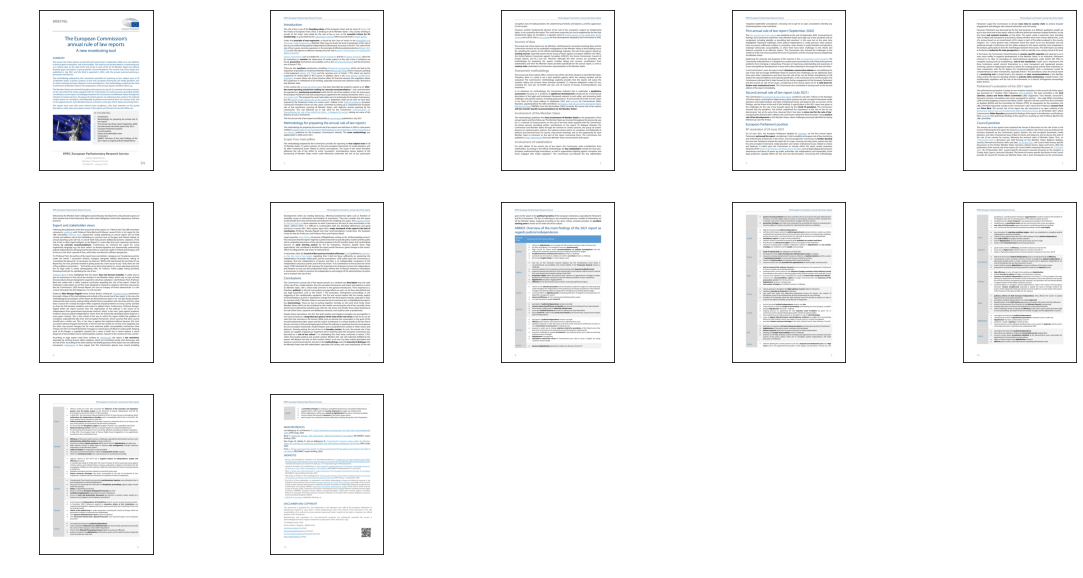

In [17]:
#@title Converting PDF to Images
filename, images = pdf_to_images(uploaded_pdf)

In [18]:
#@title Extraction of image data (text and bounding boxes)... this may take a while...
dataset, lines, row_indexes, par_boxes, line_boxes = extraction_data_from_image(images)

The text data was successfully extracted by the OCR!


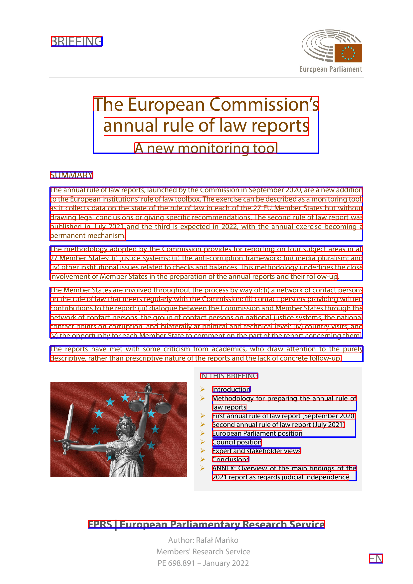

,texts,bboxes lines
0,BRIEFING,"[205, 146, 408, 184]"
1,The European Commission's,"[374, 387, 1276, 444]"
2,annual rule of law reports,"[416, 471, 1235, 542]"
3,A new monitoring tool,"[539, 571, 1109, 613]"
4,SUMMARY,"[201, 688, 371, 713]"
5,"The annual rule of law reports, launched by th...","[200, 749, 1450, 781]"
6,to the European institutions” rule of law tool...,"[201, 789, 1452, 809]"
7,as it collects data on the state of the rule o...,"[201, 828, 1452, 843]"
8,drawing legal conclusions or giving specific r...,"[201, 859, 1452, 880]"
9,published in July 2021 and the third is expect...,"[201, 894, 1452, 917]"


In [19]:
#@title (checking) Display lines bounding boxes of the first page
# https://techtutorialsx.com/2020/12/29/python-opencv-draw-rectangles/

i = 0
image = images[i].copy() # PIL
width, height = image.size
img = np.array(image, dtype='uint8') # PIL to cv2

# paragraphs
for box in par_boxes[i]:
  cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3) # blue
# lines
for box in line_boxes[i]:
  cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2) # red

img = cv2.resize(img, (int(width/4), int(height/4)))
cv2_imshow(img)
cv2.waitKey(0)

df = pd.DataFrame({"texts": lines[i], "bboxes lines": line_boxes[i]})
display(df)

### Data encoding

Now, we need to prepare our data in the format of the model.

In [20]:
encoded_dataset = dataset.map(prepare_inference_features, batched=True, batch_size=64, remove_columns=dataset.column_names)
encoded_dataset

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['images_ids', 'chunk_ids', 'input_ids', 'attention_mask', 'normalized_bboxes'],
    num_rows: 38
})

####  Checking of the encoded dataset

(Checking) Display a random annotated chunk image and its dataframe.

**Note**: the image is squared because of its normalization to 1000px vs 1000px in the encoded dataset (necessary for training the model).

  0%|          | 0/1 [00:00<?, ?ba/s]

Chunk (384 tokens) of the PDF (page: 2 / 12)

>> PDF image with bounding boxes of lines



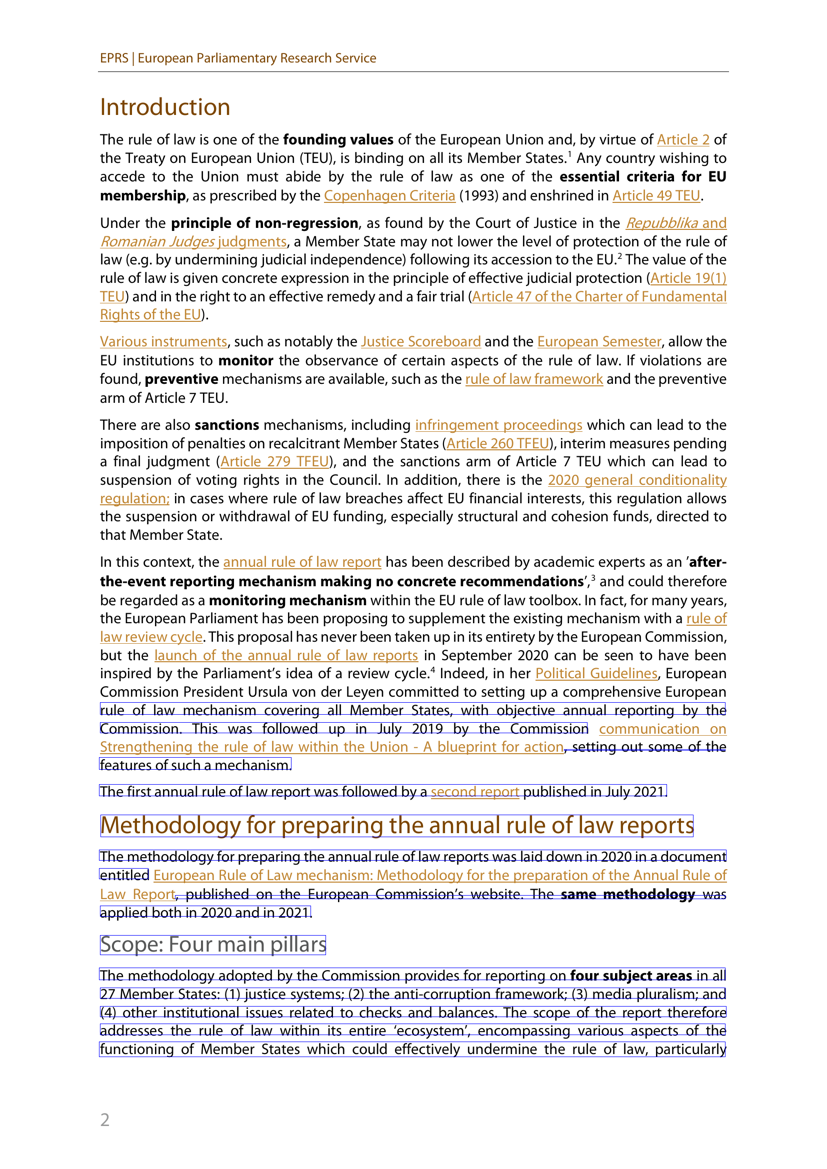


>> Dataframe of annotated lines



,texts,bboxes
0,ing by the,"[200, 1405, 1450, 1429]"
1,Commission. This was followed up in July 2019 ...,"[200, 1445, 1174, 1466]"
2,", setting out some of the","[1128, 1499, 1450, 1501]"
3,features of such a mechanism.,"[198, 1515, 582, 1539]"
4,The first annual rule of law report was follow...,"[198, 1569, 1333, 1592]"
5,Methodology for preparing the annual rule of l...,"[201, 1630, 1386, 1674]"
6,The methodology for preparing the annual rule ...,"[198, 1700, 1452, 1721]"
7,entitled,"[198, 1737, 296, 1758]"
8,+ published on the European Commission's websi...,"[350, 1791, 1450, 1798]"
9,applied both in 2020 and in 2021.,"[200, 1812, 621, 1833]"


In [21]:
# get and image from random chunk
display_chunk_lines_inference()

#### Create a custom dataset

We end our data preparation with a new class that keeps only the information needed for inference.

In [22]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # get item
    example = self.dataset[idx]
    encoding = dict()
    encoding["images_ids"] = example["images_ids"]
    encoding["chunk_ids"] = example["chunk_ids"]
    encoding["input_ids"] = example["input_ids"]
    encoding["attention_mask"] = example["attention_mask"]
    encoding["bbox"] = example["normalized_bboxes"]
    # encoding["labels"] = example["labels"]
    
    return encoding

custom_encoded_dataset = CustomDataset(encoded_dataset, tokenizer)

Now, we can get the predictions!

### Get predictions

LiLT outputs labels at the token level, but we are interested in the predicted labels at the line level.

In [23]:
#@title Get predictions (token level)
outputs, images_ids_list, chunk_ids, input_ids, bboxes = predictions_token_level(images, custom_encoded_dataset)

In [49]:
#@title Get predictions (line level)
probs_bbox, bboxes_list_dict, input_ids_dict_dict, probs_dict_dict, df = predictions_line_level(outputs, images_ids_list, chunk_ids, input_ids, bboxes)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
#@title Get labeled images with lines bounding boxes
labeled_images = get_labeled_images(images_ids_list, bboxes_list_dict, probs_dict_dict)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### Display labeled images and get their dataframes

In [51]:
print(f"Number of PDF page images: {len(labeled_images)}")

Number of PDF page images: 12


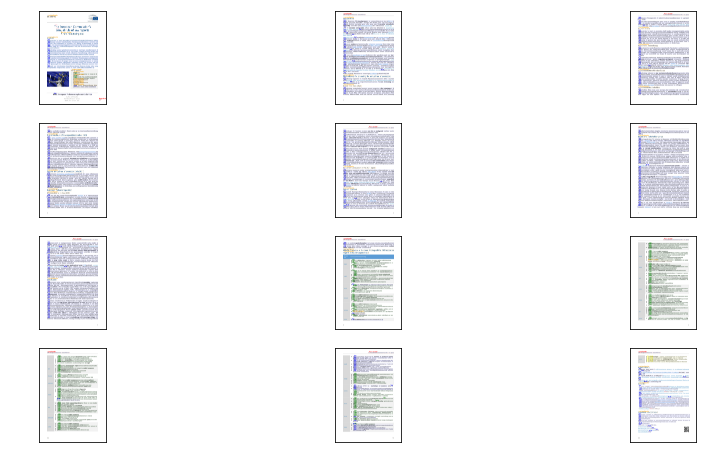

In [52]:
#@title Labeled images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))
columns = 3
for i, image in enumerate(labeled_images):
  plt.subplot(len(images) / columns + 1, columns, i + 1)
  plt.xticks(color="white")
  plt.yticks(color="white")
  plt.tick_params(bottom = False)
  plt.tick_params(left = False)
  plt.imshow(image)

Image of the labeled page 0 (at line level).


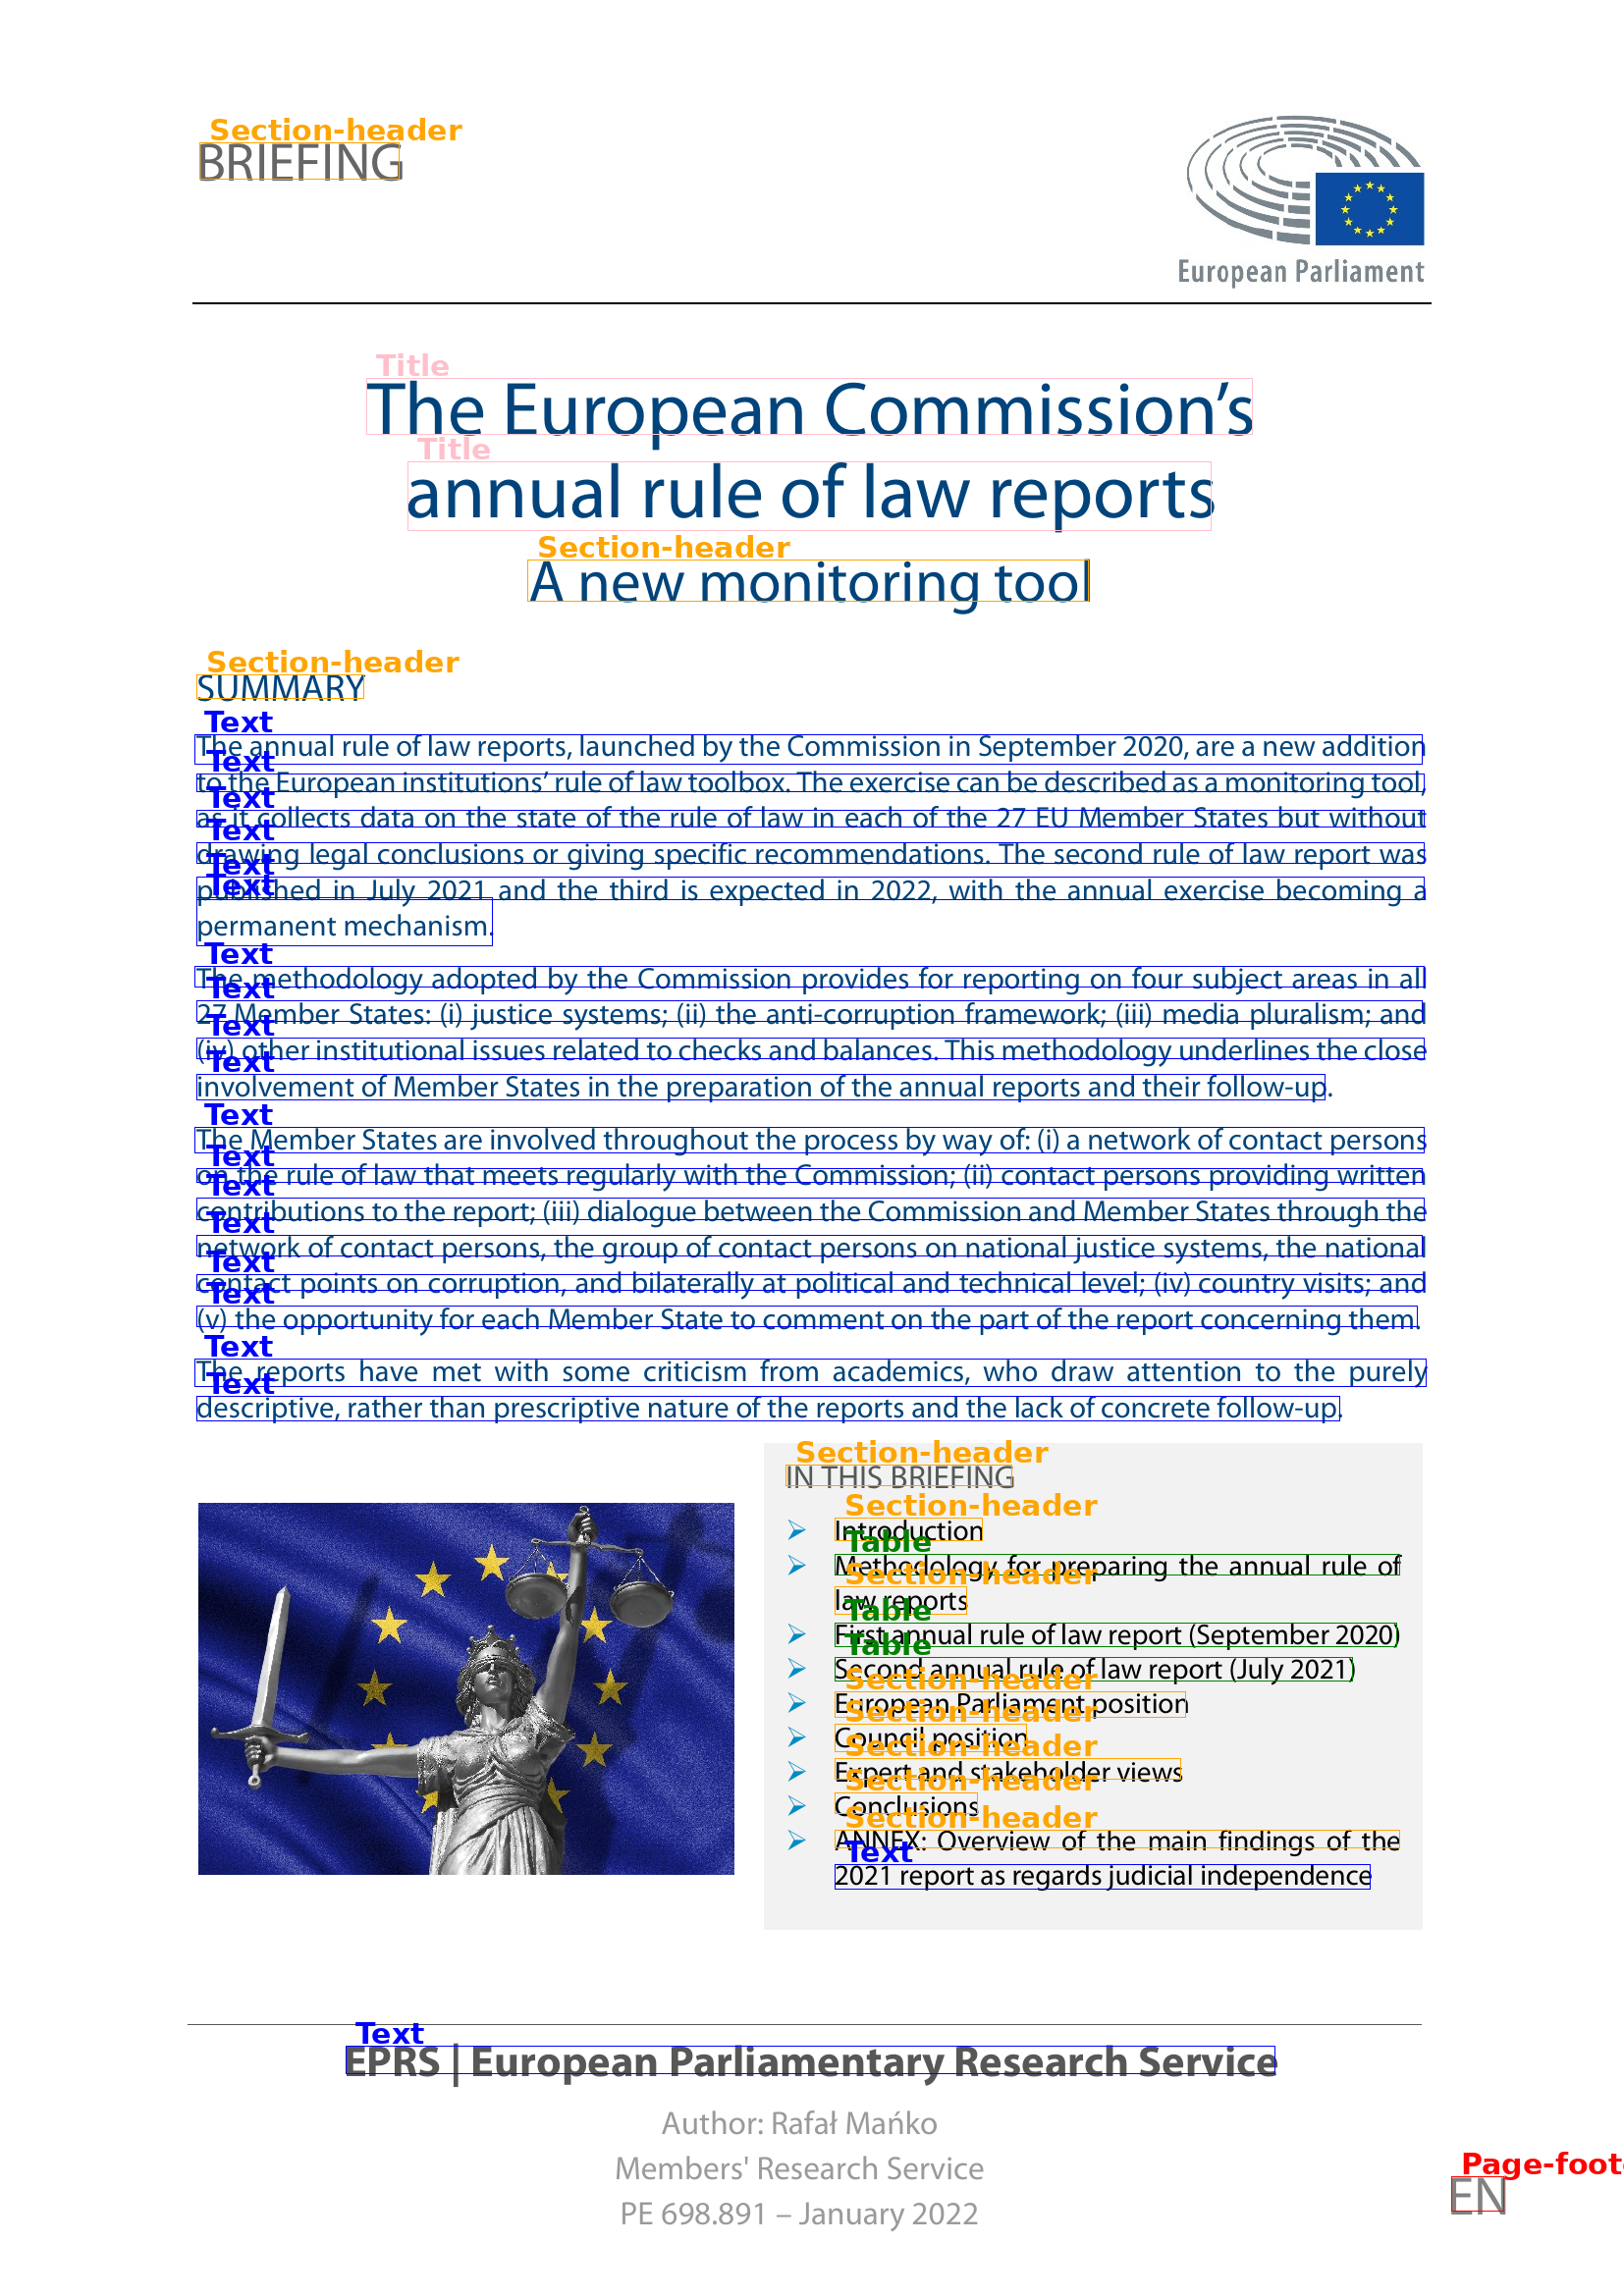

In [53]:
#@title Display one labeled image (full size)
num_page = 0

print(f"Image of the labeled page {num_page} (at line level).")
labeled_images[num_page]

In [54]:
#@title DataFrame of one image
num_page = 0

print(f"DataFrame of the page {num_page} (at line level).")
df[num_page]

DataFrame of the page 0 (at line level).


,bboxes,texts,labels
0,"[203, 145, 406, 182]",BRIEFING,Section-header
1,"[373, 385, 1275, 442]",The European Commission's,Title
2,"[415, 470, 1233, 540]",annual rule of law reports,Title
3,"[537, 570, 1108, 612]",A new monitoring tool,Section-header
4,"[200, 687, 370, 711]",SUMMARY,Section-header
5,"[198, 748, 1448, 778]","The annual rule of law reports, launched by th...",Text
6,"[200, 788, 1450, 806]",to the European institutions” rule of law tool...,Text
7,"[200, 825, 1450, 842]",as it collects data on the state of the rule o...,Text
8,"[200, 858, 1450, 879]",drawing legal conclusions or giving specific r...,Text
9,"[200, 893, 1450, 916]",published in July 2021 and the third is expect...,Text


# END